In [2]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
import time
from ctapipe.image import number_of_island_sizes
from ctapipe.image import (
    hillas_parameters,
    leakage_parameters,
    concentration_parameters,
)
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates
import ctapipe
from lstchain.io import replace_config, standard_config
import h5py
from astropy.io import fits
import json
import os


In [23]:
opt_eff_2 = []
containment = []
completeness = []
n_ring_pixels = []
event_id = []
muon_id = []
for i in range(1,500):
    #filename = f'/Users/vdk/UnrealLST/muons_new_sim/muon_table_run{i}.fits'
    filename = f'/Users/vdk/UnrealLST/optical_efficiency_scan/table_muons_0934/muon_table_run{i}.fits'
    #print(filename)
    hdul = fits.open(filename)
    # element number 10 is muon efficiency, so in such way we can check it
    for i in range(len(hdul[1].data)):
        #print(hdul[1].data[i])
        #print(hdul[1].data[i][10])
        
        #containment.append(hdul[1].data[i][11])
        #completeness.append(hdul[1].data[i][12])
        #n_ring_pixels.append(hdul[1].data[i][-4])
        if not np.isnan(hdul[1].data[i][10]):
            event_id.append(hdul[1].data[i][0])

            #print(hdul[1].data[i][10])
            opt_eff_2.append(hdul[1].data[i][10])
            muon_id.append(hdul[1].data[i][0])

opt_eff_2 = np.array(opt_eff_2)
#opt_eff_2 = opt_eff_2[np.logical_not(np.isnan(opt_eff_2))]

In [24]:
print("Mean optical efficiency = ", np.mean(opt_eff_2))
print("Number of fitted muons = ", len(opt_eff_2))
print("event id = ", event_id)
#print(muon_id)
#print(len(muon_id))
print(opt_eff_2)
print("Relative std = ", np.std(opt_eff_2)/(len(opt_eff_2)**0.5))
print( np.mean(opt_eff_2) + np.std(opt_eff_2))

Mean optical efficiency =  0.18220193335816803
Number of fitted muons =  70
event id =  [1145309, 952801, 1162900, 1153002, 1797607, 1290904, 5500, 274505, 1132206, 897003, 1123306, 1952304, 277706, 99305, 1089809, 1956307, 1522004, 1821906, 1587401, 1316506, 256902, 80300, 545907, 613307, 1659801, 1630004, 1453602, 1427702, 197603, 1433003, 620209, 1065203, 326502, 1685301, 1703300, 883500, 929403, 135708, 1916409, 876700, 1192607, 4801, 920106, 600506, 1075809, 1191002, 404107, 588304, 1054509, 1685504, 1822108, 877300, 612200, 1843501, 1385104, 1274304, 983401, 1443608, 1896808, 949103, 680005, 165909, 1200300, 462804, 453406, 1626207, 268701, 606305, 1622006, 128204]
[0.16983874 0.22874627 0.17295303 0.18163158 0.21141562 0.15597065
 0.17226812 0.18149766 0.17778404 0.22128453 0.16945713 0.17745212
 0.17464543 0.13986004 0.20307622 0.16511203 0.22074916 0.17385345
 0.17564757 0.14737811 0.14341116 0.15928168 0.1672912  0.20235082
 0.17139135 0.18747474 0.16817985 0.13102745 0.19866

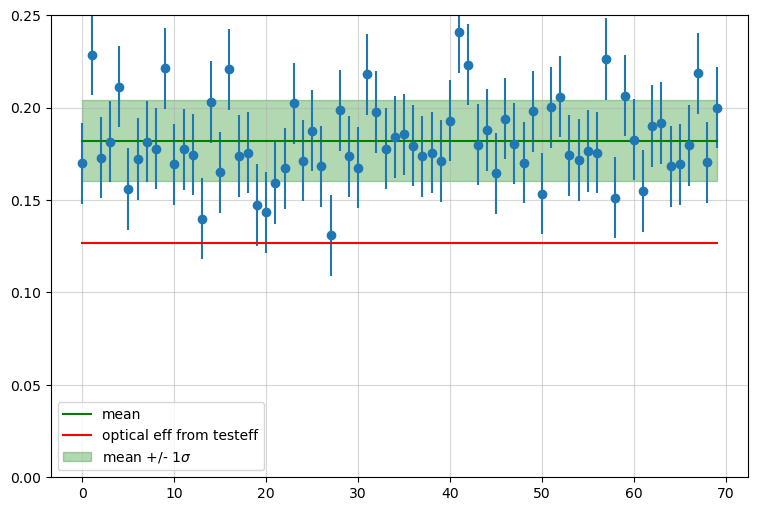

In [25]:
plt.figure(figsize = (9,6))
plt.ylim(0,0.25)
plt.grid(alpha = 0.5)
x_range = [i for i in range(len(opt_eff_2))]
y_upper = [j+np.std(opt_eff_2) for i,j in enumerate([np.mean(opt_eff_2) for i in x_range])]
y_lower = [j-np.std(opt_eff_2) for i,j in enumerate([np.mean(opt_eff_2) for i in x_range])]
plt.errorbar([i for i in range(len(opt_eff_2))],opt_eff_2, [np.std(opt_eff_2)/(0+1)**0.5 for i in range(len(opt_eff_2))],fmt='o')
plt.plot(x_range, [np.mean(opt_eff_2) for i in x_range], label = "mean", lw = 1.5, color='green')
plt.plot(x_range, [0.127 for i in x_range], label = "optical eff from testeff", lw = 1.5, color='red')
plt.fill_between(x_range, y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
plt.legend()

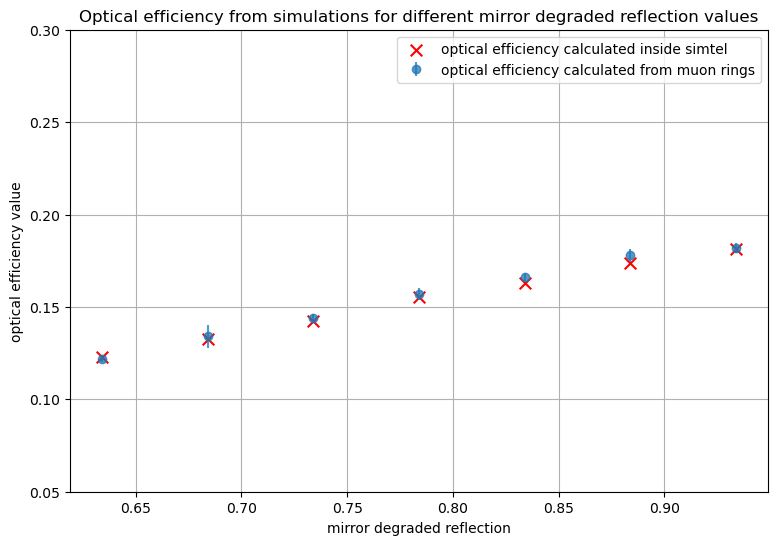

In [33]:
plt.figure(figsize = (9,6))
sim_values = [0.122, 0.134, 0.144, 0.157, 0.166, 0.178, 0.182]
#sim_std = [0.013, 0.02, 0.017, 0.025, 0.02, 0.027, 0.022]
sim_std = [0.002, 0.006, 0.002, 0.003, 0.0025, 0.0035, 0.0026]
testeff_values = [0.123, 0.132897888756, 0.142612646706,0.155327404656, 0.16304216260599996,0.173756920556, 0.181471678506]
mirror_degraded_reflection = [0.634, 0.684, 0.734, 0.784, 0.834, 0.884, 0.934]


plt.ylim(0.05,0.3)
plt.grid()
plt.errorbar(mirror_degraded_reflection, sim_values, sim_std, fmt = 'o', alpha = 0.75, label = 'optical efficiency calculated from muon rings')
plt.scatter(mirror_degraded_reflection, testeff_values, marker = 'x', s = 70, color = 'red', label = 'optical efficiency calculated inside simtel')
plt.xlabel("mirror degraded reflection")
plt.ylabel("optical efficiency value")
plt.title("Optical efficiency from simulations for different mirror degraded reflection values")
plt.legend()

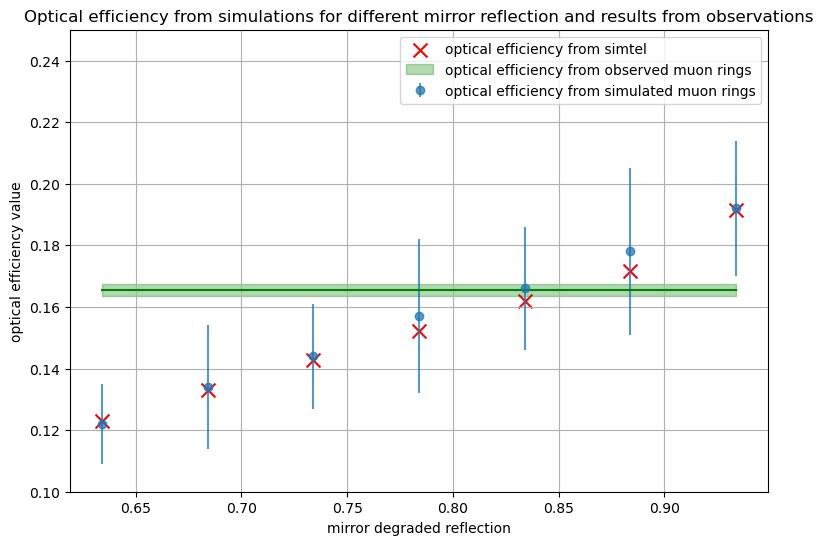

In [28]:

plt.figure(figsize = (9,6))
sim_values = [0.122, 0.134, 0.144, 0.157, 0.166, 0.178, 0.192]
sim_std = [0.013, 0.02, 0.017, 0.025, 0.02, 0.027, 0.022]
#sim_std = [0.002, 0.02, 0.017, 0.025, 0.02, 0.027, 0.022]
testeff_values = [0.123, 0.132897888756, 0.142612646706,0.152327404656, 0.16204216260599996,0.171756920556, 0.191471678506]
mirror_degraded_reflection = [0.634, 0.684, 0.734, 0.784, 0.834, 0.884, 0.934]


plt.ylim(0.1,0.25)
plt.errorbar(mirror_degraded_reflection, sim_values, sim_std, fmt = 'o', alpha = 0.75, label = 'optical efficiency from simulated muon rings')
plt.scatter(mirror_degraded_reflection, testeff_values, marker = 'x', s = 100, color = 'red', label = 'optical efficiency from simtel')
plt.xlabel("mirror degraded reflection")
plt.ylabel("optical efficiency value")

cuts = mirror_degraded_reflection
true_opt_eff = [0.1654 for i in cuts]
y_upper = [0.1654+0.002 for i in cuts]
y_lower = [0.1654-0.002 for i in cuts]

flagged_opt_eff = [0.1652, 0.1652, 0.1655, 0.1637, 0.1644, 0.1672, 0.1732]
opt_eff_err = [0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.005]
#plt.errorbar(x = cuts, y = flagged_opt_eff, yerr = opt_eff_err,fmt='o', ms = 7, alpha = 1, label = 'after flagging', color = 'black')
plt.fill_between(mirror_degraded_reflection, y_upper, y_lower, alpha = 0.3, color = 'green', label = 'optical efficiency from observed muon rings')
plt.plot(cuts, true_opt_eff, color = 'green')#, label = 'without flagging')
plt.grid()
plt.title("Optical efficiency from simulations for different mirror reflection and results from observations")
plt.legend()

In [58]:
true_opt_eff

[0.1654, 0.1654, 0.1654, 0.1654, 0.1654, 0.1654, 0.1654]